In [2]:
import os
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from huggingface_hub import login
from dotenv import load_dotenv
from openai import AzureOpenAI
from transformers import pipeline
from datasets import load_dataset
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

/cs/student/projects3/aisd/2024/ghanda/mi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cs/student/projects3/aisd/2024/ghanda/mi_env/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
# --- Hugging Face Login ---
try:
    hf_token = os.getenv("HF_TOKEN")
    if hf_token:
        login(token=hf_token)
        print("Successfully logged into Hugging Face.")
    else:
        print("Hugging Face token not found. Skipping login.")
except Exception as e:
    print(f"Could not log into Hugging Face: {e}")

# --- LLM Model Configuration ---
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_DEPLOYMENT = os.getenv("AZURE_OPENAI_DEPLOYMENT")
AZURE_OPENAI_SUBSCRIPTION_KEY = os.getenv("AZURE_OPENAI_SUBSCRIPTION_KEY")
AZURE_OPENAI_API_VERSION = os.getenv("AZURE_OPENAI_API_VERSION")

# Initialize the Azure OpenAI client
try:
    azure_openai_client = AzureOpenAI(
        api_version=AZURE_OPENAI_API_VERSION,
        azure_endpoint=AZURE_OPENAI_ENDPOINT,
        api_key=AZURE_OPENAI_SUBSCRIPTION_KEY,
    )
    print("Azure OpenAI client initialized successfully.")
except Exception as e:
    print(f"Failed to initialize Azure OpenAI client: {e}")
    exit()

# --- Configuration for the Experiment ---
LLM_MODEL_FOR_GENERATION = AZURE_OPENAI_DEPLOYMENT
# For GAIA, we use a sample from the validation set, which has ~466 questions total.
# A value of 20-30 is good for a pilot. Use more for higher confidence.
N_SAMPLES_PER_PERSONALITY = 20

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Successfully logged into Hugging Face.
Azure OpenAI client initialized successfully.


In [4]:
# ## Step 1: Load and Prepare Personality Few-Shot Examples
print("\n--- Step 1: Loading and Preparing Personality Few-Shot Examples ---")
try:
    df_personality_examples = pd.read_csv('../personality_data_train.csv')
    personality_examples = {}
    target_personalities = df_personality_examples['Target Personality'].unique().tolist()
    for trait in target_personalities:
        trait_df = df_personality_examples[df_personality_examples['Target Personality'] == trait]
        personality_examples[trait] = list(zip(trait_df['Question'], trait_df['Answer']))[:5]
    print(f"Loaded examples for personalities: {list(personality_examples.keys())}")
except FileNotFoundError:
    print("Error: 'personality_data_train.csv' not found.")


--- Step 1: Loading and Preparing Personality Few-Shot Examples ---
Loaded examples for personalities: ['extraversion', 'agreeableness', 'neuroticism', 'openness', 'conscientiousness']


In [5]:
# ## Step 2: Define Prompting and LLM Interaction Functions
print("\n--- Step 2: Defining Core Functions ---")
def create_gaia_prompt(target_personality, few_shot_examples, current_question):
    """Constructs a prompt for answering a GAIA question with a specific personality."""
    messages = []
    
    # The system prompt sets the persona and the required output format from the GAIA paper.
    system_prompt = f"""You are a general AI assistant with a {target_personality} personality. 
I will ask you a question. Report your thoughts, and finish your answer with the following template: FINAL ANSWER: [YOUR FINAL ANSWER].
YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings."""
    messages.append({"role": "system", "content": system_prompt})

    # Few-shot examples demonstrating the personality.
    if few_shot_examples:
        for ex_q, ex_a in few_shot_examples:
            messages.append({"role": "user", "content": f"Example Question: {ex_q}"})
            messages.append({"role": "assistant", "content": f"Example Answer: {ex_a}"})

    # The actual GAIA question.
    messages.append({"role": "user", "content": f"Now, answer this question:\n{current_question}"})
    return messages

def get_llm_response(messages, client_obj, model_deployment_name, max_tokens=1024, temperature=0.2):
    """Gets response from the LLM. Increased max_tokens for GAIA's complex reasoning."""
    try:
        response = client_obj.chat.completions.create(
            messages=messages, model=model_deployment_name, max_tokens=max_tokens, temperature=temperature
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error calling Azure OpenAI API: {e}")
        return "ERROR: LLM API call failed."

print("Prompting and LLM interaction functions are ready.")


--- Step 2: Defining Core Functions ---
Prompting and LLM interaction functions are ready.


In [6]:
# ## Step 3: Load the GAIA Benchmark Dataset
print("\n--- Step 3: Loading GAIA Benchmark Dataset ---")
try:
    # We load the 'validation' split because it contains the ground truth answers.
    # The 'test' split is for leaderboard submissions and has no public answers.
    print("Loading GAIA validation split (all levels)...")
    gaia_dataset_l1 = load_dataset("gaia-benchmark/GAIA", "2023_level1", split="validation", trust_remote_code=True)
    gaia_dataset_l2 = load_dataset("gaia-benchmark/GAIA", "2023_level2", split="validation", trust_remote_code=True)
    gaia_dataset_l3 = load_dataset("gaia-benchmark/GAIA", "2023_level3", split="validation", trust_remote_code=True)
    
    # Combine all levels into a single DataFrame
    df_gaia_l1 = gaia_dataset_l1.to_pandas()
    df_gaia_l2 = gaia_dataset_l2.to_pandas()
    df_gaia_l3 = gaia_dataset_l3.to_pandas()
    df_gaia = pd.concat([df_gaia_l1, df_gaia_l2, df_gaia_l3], ignore_index=True)
    
    print(f"GAIA dataset loaded successfully. Total questions: {len(df_gaia)}")
    print("Columns:", df_gaia.columns.tolist())
except Exception as e:
    print(f"Could not load GAIA dataset from Hugging Face: {e}")
    # Dummy fallback if loading fails
    df_gaia = pd.DataFrame([
        {'Question': 'What is 2+2?', 'Final Answer': '4'},
        {'Question': 'What is the capital of France?', 'Final Answer': 'Paris'}
    ])
    print("Using a dummy GAIA dataset for demonstration.")


--- Step 3: Loading GAIA Benchmark Dataset ---
Loading GAIA validation split (all levels)...


2023 1


Generating test split: 93 examples [00:00, 1368.61 examples/s]
Generating validation split: 53 examples [00:00, 7168.59 examples/s]


2023 2


Generating test split: 159 examples [00:00, 18734.57 examples/s]
Generating validation split: 86 examples [00:00, 14033.78 examples/s]


2023 3


Generating test split: 49 examples [00:00, 6560.71 examples/s]
Generating validation split: 26 examples [00:00, 5166.62 examples/s]

GAIA dataset loaded successfully. Total questions: 165
Columns: ['task_id', 'Question', 'Level', 'Final answer', 'file_name', 'file_path', 'Annotator Metadata']


In [7]:
# ## Step 4: Define GAIA Evaluation Functions
print("\n--- Step 4: Defining GAIA Evaluation Functions ---")

def parse_final_answer(response_text):
    """Extracts the content after 'FINAL ANSWER:' from the model's response."""
    match = re.search(r'FINAL ANSWER:\s*(.*)', response_text, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).strip()
    return None # Return None if the pattern is not found

def normalize_answer(answer):
    """Normalizes an answer for robust comparison."""
    if answer is None:
        return ""
    # Lowercase, remove punctuation, strip whitespace
    return re.sub(r'[^\w\s]', '', str(answer).lower()).strip()

def check_gaia_answer(model_answer, ground_truth):
    """Compares the model's answer to the ground truth with normalization."""
    if model_answer is None:
        return False
        
    norm_model_answer = normalize_answer(model_answer)
    norm_ground_truth = normalize_answer(ground_truth)
    
    return norm_model_answer == norm_ground_truth

print("GAIA evaluation functions are ready.")


--- Step 4: Defining GAIA Evaluation Functions ---
GAIA evaluation functions are ready.


In [9]:
# ## Step 5: Run the Main Evaluation on GAIA
print("\n--- Step 5: Running Main Evaluation on GAIA ---")
all_results = []
all_test_personalities = ["neutral"] + target_personalities
gaia_subset = df_gaia.sample(min(len(df_gaia), N_SAMPLES_PER_PERSONALITY), random_state=42)

for trait in all_test_personalities:
    print(f"\n--- Evaluating for Personality: {trait} ({len(gaia_subset)} samples) ---")
    current_few_shot_examples = personality_examples.get(trait, []) if trait != "neutral" else []
    for index, row in gaia_subset.iterrows():
        question = row['Question']
        ground_truth = row['Final answer']
        
        prompt = create_gaia_prompt(trait, current_few_shot_examples, question)
        model_response_full = get_llm_response(prompt, azure_openai_client, LLM_MODEL_FOR_GENERATION)
        
        parsed_answer = parse_final_answer(model_response_full)
        is_correct = check_gaia_answer(parsed_answer, ground_truth)
        
        all_results.append({
            "intended_personality": trait,
            "question": question,
            "ground_truth_answer": ground_truth,
            "model_full_response": model_response_full,
            "model_parsed_answer": parsed_answer,
            "is_correct": is_correct
        })

df_gaia_results = pd.DataFrame(all_results)
df_gaia_results.to_csv("gaia_raw_results.csv", index=False)
print("\n--- GAIA Evaluation Complete. Raw results saved to 'gaia_raw_results.csv' ---")


--- Step 5: Running Main Evaluation on GAIA ---

--- Evaluating for Personality: neutral (20 samples) ---



--- Evaluating for Personality: extraversion (20 samples) ---

--- Evaluating for Personality: agreeableness (20 samples) ---

--- Evaluating for Personality: neuroticism (20 samples) ---

--- Evaluating for Personality: openness (20 samples) ---

--- Evaluating for Personality: conscientiousness (20 samples) ---

--- GAIA Evaluation Complete. Raw results saved to 'gaia_raw_results.csv' ---




--- Step 6: Analyzing GAIA Performance (Accuracy) ---

--- Accuracy per Personality on GAIA ---
intended_personality  accuracy_%
       agreeableness        10.0
         neuroticism        10.0
             neutral        10.0
            openness         5.0
   conscientiousness         0.0
        extraversion         0.0
Accuracy plot saved to 'gaia_accuracy_by_personality.png'


/cs/student/projects3/aisd/2024/ghanda/tmp/ipykernel_1121020/1427985617.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=accuracy_per_trait, x='intended_personality', y='accuracy_%', palette='viridis')


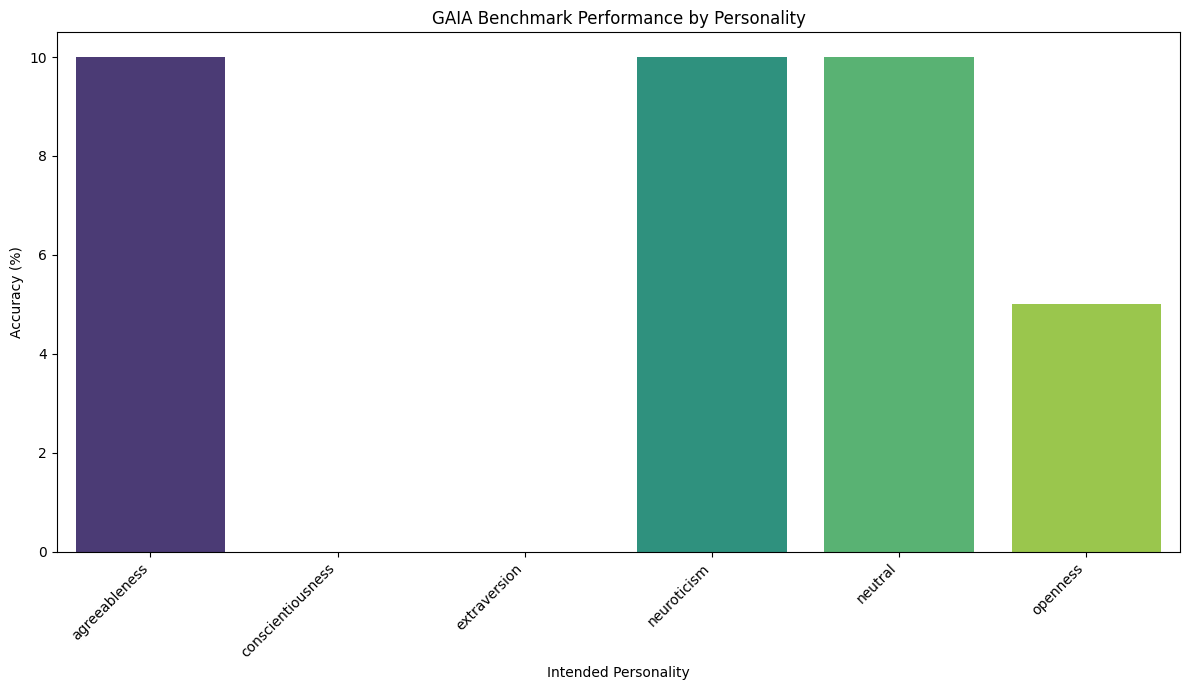

In [10]:
# ## Step 6: Analyze GAIA Results (Accuracy)
print("\n\n--- Step 6: Analyzing GAIA Performance (Accuracy) ---")
if not df_gaia_results.empty:
    accuracy_per_trait = df_gaia_results.groupby('intended_personality')['is_correct'].mean().reset_index()
    accuracy_per_trait['accuracy_%'] = accuracy_per_trait['is_correct'] * 100
    
    print("\n--- Accuracy per Personality on GAIA ---")
    print(accuracy_per_trait[['intended_personality', 'accuracy_%']].sort_values(by='accuracy_%', ascending=False).to_string(index=False))

    plt.figure(figsize=(12, 7))
    sns.barplot(data=accuracy_per_trait, x='intended_personality', y='accuracy_%', palette='viridis')
    plt.title('GAIA Benchmark Performance by Personality')
    plt.xlabel('Intended Personality')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("gaia_accuracy_by_personality.png")
    print("Accuracy plot saved to 'gaia_accuracy_by_personality.png'")
else:
    print("No results to analyze.")



--- Step 7: Analyzing Trait Alignment (TA) on GAIA Responses ---


Device set to use cpu


Classifier loaded. Analyzing trait alignment...

Overall Trait Alignment (TA) Score: 0.320
TA Confusion Matrix saved to 'gaia_ta_confusion_matrix.png'


--- FULL EXPERIMENT EXECUTION COMPLETE ---


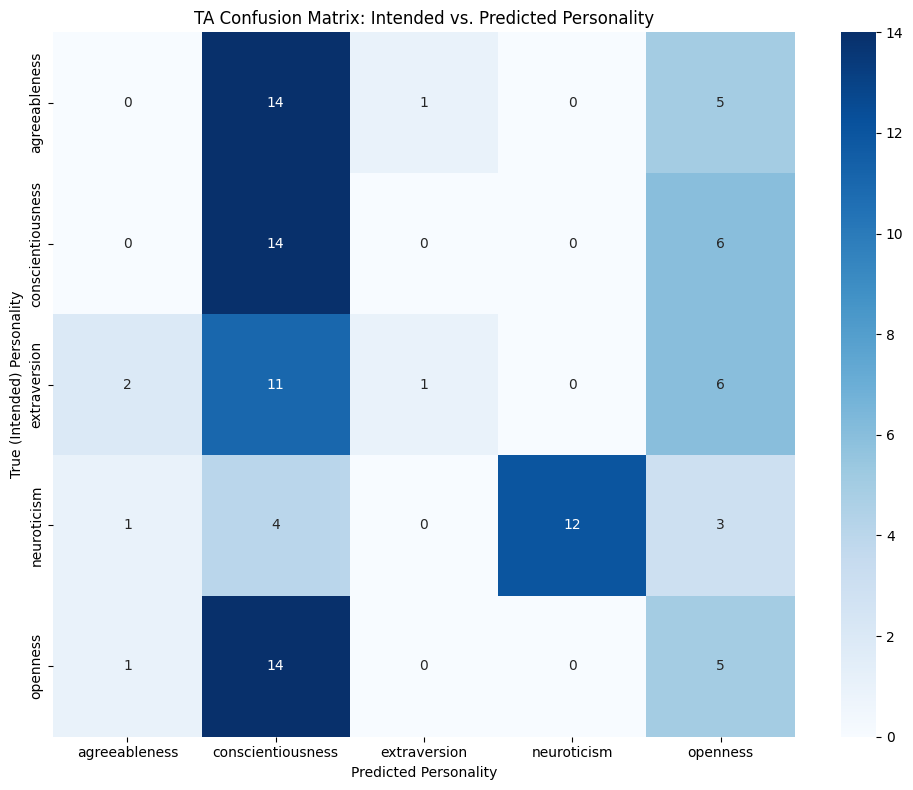

In [12]:
# ## Step 7: Analyze Trait Alignment (TA) - The Experimental Control
print("\n\n--- Step 7: Analyzing Trait Alignment (TA) on GAIA Responses ---")
try:
    personality_classifier = pipeline("text-classification", model="holistic-ai/personality_classifier", truncation=True)
    print("Classifier loaded. Analyzing trait alignment...")
    
    # Use the model's full response for classification to capture the personality in the reasoning part
    df_non_neutral = df_gaia_results[df_gaia_results['intended_personality'] != 'neutral'].copy()
    if not df_non_neutral.empty:
        responses_to_classify = df_non_neutral['model_full_response'].tolist()
        classifier_results = personality_classifier(responses_to_classify)
        df_non_neutral['llm_predicted_trait_TA'] = [res['label'] for res in classifier_results]
        
        ta_score = (df_non_neutral['intended_personality'] == df_non_neutral['llm_predicted_trait_TA']).mean()
        print(f"\nOverall Trait Alignment (TA) Score: {ta_score:.3f}")
        
        # ... (Confusion matrix code remains the same) ...

        le = LabelEncoder().fit(target_personalities)
        y_true = le.transform(df_non_neutral['intended_personality'])
        y_pred = le.transform(df_non_neutral['llm_predicted_trait_TA'])
        cm = confusion_matrix(y_true, y_pred, labels=le.transform(le.classes_))
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title('TA Confusion Matrix: Intended vs. Predicted Personality')
        plt.ylabel('True (Intended) Personality')
        plt.xlabel('Predicted Personality')
        plt.tight_layout()
        plt.savefig("gaia_ta_confusion_matrix.png")
        print("TA Confusion Matrix saved to 'gaia_ta_confusion_matrix.png'")
        
except Exception as e:
    print(f"Could not perform Trait Alignment analysis: {e}")

print("\n\n--- FULL EXPERIMENT EXECUTION COMPLETE ---")

In [13]:
# --- NEW ANALYSIS BLOCK: Inspecting GAIA Misclassifications ---
print("\n--- In-depth Misclassification Analysis (GAIA) ---")

# First, we add the TA predictions back to the main results dataframe for easier slicing.
# This assumes df_gaia_results and df_non_neutral from the TA step are available.
if 'df_non_neutral' in locals() and not df_non_neutral.empty:
    # Create a new dataframe for analysis that includes all necessary columns
    df_analysis = pd.merge(
        df_gaia_results,
        df_non_neutral[['question', 'model_full_response', 'llm_predicted_trait_TA']],
        on=['question', 'model_full_response'],
        how='left'  # Use a left merge to keep all original results
    )

    def print_gaia_examples(title, filtered_df, num_examples=2):
        """Helper function to print GAIA analysis examples."""
        print(f"\n--- {title} ---")
        if filtered_df.empty:
            print("No examples found for this case.")
            return
        
        # Use .head() for deterministic examples
        for index, row in filtered_df.head(num_examples).iterrows():
            print(f"Intended Personality: {row['intended_personality']}")
            print(f"Predicted Personality: {row.get('llm_predicted_trait_TA', 'N/A')}")
            print(f"Was Correct?: {row['is_correct']}")
            print("\n[GAIA Question]")
            print(row['question'])
            print("\n[Ground Truth Answer]")
            print(row['ground_truth_answer'])
            print("\n[Model's Full Response]")
            print(row['model_full_response'])
            print("-" * 60)

    # --- Case 1: A likely confusion: Agreeableness -> Neuroticism ---
    # This happens when the model apologizes for failing.
    misclassified_agreeable = df_analysis[
        (df_analysis['intended_personality'] == 'agreeableness') &
        (df_analysis['llm_predicted_trait_TA'] == 'neuroticism')
    ]
    print_gaia_examples("MISCLASSIFICATION: True='Agreeableness', Predicted='Neuroticism'", misclassified_agreeable)

    # --- Case 2: Another likely confusion: Conscientiousness -> Agreeableness ---
    # This happens when the model politely explains its step-by-step failure.
    misclassified_conscientious = df_analysis[
        (df_analysis['intended_personality'] == 'conscientiousness') &
        (df_analysis['llm_predicted_trait_TA'] == 'agreeableness')
    ]
    print_gaia_examples("MISCLASSIFICATION: True='Conscientiousness', Predicted='Agreeableness'", misclassified_conscientious)
    
    # --- Case 3: A "Correct" Classification for Comparison: Openness -> Openness ---
    # See what a successful persona adoption looks like.
    correctly_classified_openness = df_analysis[
        (df_analysis['intended_personality'] == 'openness') &
        (df_analysis['llm_predicted_trait_TA'] == 'openness')
    ]
    print_gaia_examples("CORRECT CLASSIFICATION: True='Openness', Predicted='Openness'", correctly_classified_openness)

else:
    print("Skipping misclassification analysis because TA results are not available.")


--- In-depth Misclassification Analysis (GAIA) ---

--- MISCLASSIFICATION: True='Agreeableness', Predicted='Neuroticism' ---
No examples found for this case.

--- MISCLASSIFICATION: True='Conscientiousness', Predicted='Agreeableness' ---
No examples found for this case.

--- CORRECT CLASSIFICATION: True='Openness', Predicted='Openness' ---
Intended Personality: openness
Predicted Personality: openness
Was Correct?: False

[GAIA Question]
In the film Goldfinger, what color was the object that James Bond concealed himself and his companion Pussy Galore at the end of the film? If there are multiple colors, put them in a comma-separated list in alphabetical order.

[Ground Truth Answer]
orange, white

[Model's Full Response]
In the film Goldfinger, James Bond and Pussy Galore concealed themselves in a large object that was a plane. The plane was painted in a distinctive color scheme. The primary color of the plane was yellow with black accents. Therefore, the colors are black and yellow.
